# Day-to-day evolution of supply and demand
Module for simulating ridesourcing evolution

Contribution by Arjan de Ruijter - a.j.f.deruijter@tudelft.nl

In [2]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim and MaaSSim/MaaSSim to path (not needed if already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from MaaSSim.utils import save_config, get_config, load_G, generate_demand, initialize_df, empty_series, \
    slice_space, test_space
from MaaSSim.maassim import Simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.d2d_sim import *
from MaaSSim.d2d_demand import *
from MaaSSim.d2d_supply import *
from MaaSSim.shared import prep_shared_rides
from MaaSSim.decisions import dummy_False

In [4]:
import pandas as pd
import zipfile
import logging
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.use('ggplot')

In [5]:
# Load config
params = get_config('../../data/config/ams.json')  # load configuration

In [6]:
# Experiment replications and number of threads to be used
params.parallel.nReplications = 1
params.parallel.nThread = 1

# Main experimental settings
params.nP = 2000 # travellers
params.nV = 20 # drivers
params.nD = 5 # days
params.simTime = 8 # hours

In [7]:
# Other day-to-day settings
params.evol.drivers.omega = 5 # recency: until this day perfect memory, afterwards weight 1/recency for last experience
params.evol.drivers.res_wage.mean = 80 #euros
params.evol.drivers.res_wage.std = 10 #euros
params.evol.drivers.init_inc_ratio = 1 #expected income of informed drivers at start of sim as ratio of res wage

params.evol.drivers.inform.prob_start = 1 # probability of being informed at start of sim
params.evol.drivers.inform.beta = 0.2 # information transmission rate

params.evol.drivers.regist.prob_start = 1 # probability of being registered if informed at start of sim
params.evol.drivers.regist.beta = 0.2 # registration choice model parameter
params.evol.drivers.regist.cost_comp = 10 # daily share of registration costs (euros)
params.evol.drivers.regist.samp = 0.2 # probability of making regist decision when informed (and unregistered)

params.evol.drivers.particip.beta = 0.1 # participation choice model parameter
params.evol.drivers.particip.probabilistic = True # stochasticity in participation choice

params.evol.travellers.inform.prob_start = 1
params.evol.travellers.inform.beta = 0.2
params.evol.travellers.reject_penalty = 30 * 60 # seconds
params.evol.travellers.omega = 5 # recency: until this day perfect memory, afterwards weight 1/recency for last experience

# Financial settings
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = 1.63 #euro/km
params.platforms.min_fare = 6 # euro
params.platforms.comm_rate = 0.25 #rate
params.drivers.fuel_costs = 0.25 #euro/km

# Properties alternative modes
params.alt_modes.pt.base_fare = 0.99 # euro
params.alt_modes.pt.km_fare = 0.174 # euro/km
params.alt_modes.pt.access_time = 10 * 60  #s, includes egress (not waiting)
params.alt_modes.pt.wait_time = 7.5 * 60 #s
params.alt_modes.car.km_cost = 0.5 # euro/km
params.alt_modes.car.park_cost = 5 # euro
params.alt_modes.car.access_time = 10 * 60 # s
params.speeds.bike = 4 # m/s
params.speeds.pt = 0.5 * params.speeds.ride # considering stops

# Mode choice parameters
params.mode_choice.ASC_car = 0 # util, rel to bike
params.mode_choice.ASC_rs = 0
params.mode_choice.ASC_pt = 0
params.mode_choice.beta_access = -0.0475 / 60 # util/s
params.mode_choice.beta_cost = -0.1515 # util/euro
params.mode_choice.beta_time_bike = -0.0693 / 60 #util/s
params.mode_choice.beta_time_moto = -0.0106 / 60
params.mode_choice.beta_wait_rs = -0.0156 / 60
params.mode_choice.beta_wait_pt = -0.0398 / 60

# Demand settings
params.demand_structure.origins_dispertion = -0.0003
params.demand_structure.destinations_dispertion = -0.0003
params.dist_threshold_min = 2000 # min dist
params.dist_threshold = 100000 # max dist

# Start time
params.t0 = pd.Timestamp.now()

In [8]:
inData = load_G(inData, params, stats=True)  # download graph for the 'params.city' and calc the skim matrices
inData = generate_demand(inData, params, avg_speed = True)
inData.passengers['informed'] = np.random.rand(params.nP) < params.evol.travellers.inform.prob_start
inData.passengers['expected_wait'] = 0
fixed_supply = generate_vehicles_d2d(inData, params)
inData.vehicles = fixed_supply.copy()
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = pd.concat([inData.platforms,pd.DataFrame(columns=['base_fare','comm_rate','min_fare'])])
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[params.platforms.fare,'Uber',30,params.platforms.base_fare,params.platforms.comm_rate,params.platforms.min_fare,]

inData = prep_shared_rides(inData, params.shareability)  # prepare schedules

In [9]:
d2d = DotMap()
d2d.drivers = dict()
d2d.travs = dict()
sim = Simulator(inData, params=params,
                    kpi_veh = D2D_veh_exp,
                    kpi_pax = d2d_kpi_pax,
                    f_driver_out = D2D_driver_out,
                    f_trav_out = d2d_no_request,
                    f_trav_mode = dummy_False,
                    logger_level=logging.WARNING)  # initialize

for day in range(params.get('nD', 1)):  # run iterations
    sim.make_and_run(run_id=day)  # prepare and SIM
    sim.output()  # calc results

    d2d.drivers[day] = update_d2d_drivers(sim=sim,params=params)
    d2d.travs[day] = update_d2d_travellers(sim=sim,params=params)
    res_inf_driver = wom_driver(inData, params = params)
    inData.vehicles.informed = res_inf_driver
    res_regist = platform_regist(inData, d2d.drivers[day], params = params)
    inData.vehicles.registered = res_regist.registered
    inData.vehicles.expected_income = res_regist.expected_income
    inData.vehicles.pos = fixed_supply.pos
    res_inf_trav = wom_trav(inData, params = params)
    inData.passengers.informed = res_inf_trav
    new_wait = d2d.travs[day].new_perc_wait.copy()
    inData.passengers.expected_wait = new_wait.reset_index(drop = True)

07-04-21 15:00:52-WARNING-Setting up 8h simulation at 2021-04-07 11:00:09 for 20 vehicles and 2000 passengers in Amsterdam, Netherlands
07-04-21 15:01:30-WARNING-day 0: simulation time 30.6 s
07-04-21 15:01:32-WARNING-assertion tests for simulation results - passed
07-04-21 15:02:12-WARNING-day 1: simulation time 33.3 s
07-04-21 15:02:15-WARNING-assertion tests for simulation results - passed
07-04-21 15:02:49-WARNING-day 2: simulation time 27.7 s
07-04-21 15:02:51-WARNING-assertion tests for simulation results - passed
07-04-21 15:03:26-WARNING-day 3: simulation time 29.0 s
07-04-21 15:03:29-WARNING-assertion tests for simulation results - passed
07-04-21 15:03:58-WARNING-day 4: simulation time 23.2 s
07-04-21 15:04:00-WARNING-assertion tests for simulation results - passed


In [31]:
evol_micro, evol_agg = D2D_summary(d2d=d2d) # multi-day stats

In [32]:
with zipfile.ZipFile('evol.zip', 'w') as csv_zip:
    csv_zip.writestr("evol_agg_supply.csv", evol_agg.supply.to_csv())
    csv_zip.writestr("evol_agg_demand.csv", evol_agg.demand.to_csv())

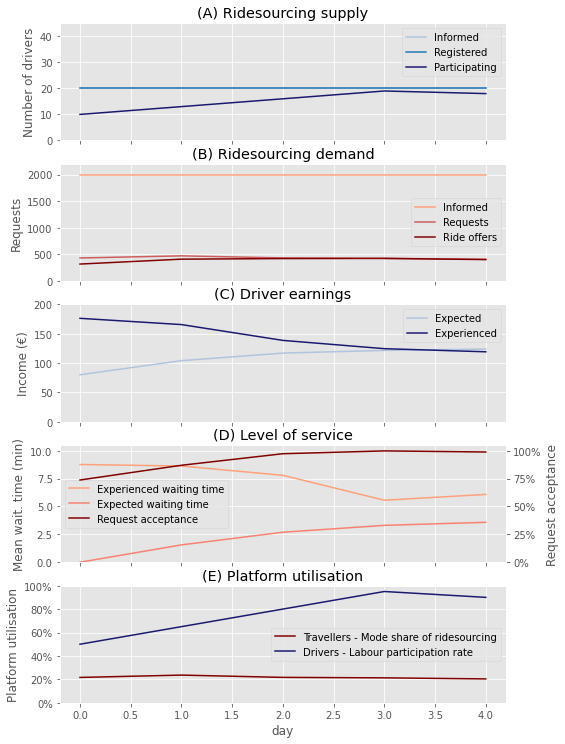

In [35]:
# Plot number of drivers and income
fig, axes = plt.subplots(nrows=5, ncols=1, figsize = (8,12.5), sharex = True)
evol_agg.supply[['inform','regist','particip']].plot(ax = axes[0], color=['lightsteelblue','tab:blue','midnightblue'])
axes[0].set_title('(A) Ridesourcing supply')
axes[0].legend(['Informed','Registered','Participating'])
axes[0].set_ylim([0,params.nV + 25])
axes[0].set_ylabel('Number of drivers')
evol_agg.supply[['mean_perc_inc','mean_exp_inc']].plot(ax = axes[2], color=['lightsteelblue','midnightblue'])
axes[2].set_title('(C) Driver earnings')
axes[2].legend(['Expected','Experienced'])
axes[2].set_ylim([0,math.ceil(max(evol_agg.supply.mean_perc_inc.max(),evol_agg.supply.mean_exp_inc.max())/50)*50])
axes[2].set_ylabel('Income (\u20ac)')

evol_agg.demand[['inform','requests','gets_offer']].plot(ax = axes[1], color=['lightsalmon','indianred','maroon'])
axes[1].set_title('(B) Ridesourcing demand')
axes[1].legend(['Informed','Requests','Ride offers'])
axes[1].set_ylim([0,params.nP * 1.1])
axes[1].set_ylabel('Requests')

ax_sec = axes[3].twinx()
evol_agg.demand['proport_match'] = evol_agg.demand.gets_offer / evol_agg.demand.requests * 100
evol_agg.demand['mean_wait'].apply(lambda x: 1/60 * x).plot(ax = axes[3], label='Experienced waiting time', color ='lightsalmon')
evol_agg.demand['perc_wait'].apply(lambda x: 1/60 * x).plot(ax = axes[3], label='Expected waiting time', color ='salmon')
evol_agg.demand['proport_match'].plot(ax = ax_sec, color = 'maroon', label='Request acceptance')
lines_1, labels_1 = axes[3].get_legend_handles_labels()
lines_2, labels_2 = ax_sec.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
axes[3].legend(lines, labels, loc=0)
axes[3].set_title('(D) Level of service')
axes[3].set_ylabel('Mean wait. time (min)')
ax_sec.set_ylabel('Request acceptance')
ax_sec.yaxis.set_major_formatter(mtick.PercentFormatter())
axes[3].set_ylim([0,math.ceil(evol_agg.demand[['mean_wait']].apply(lambda x: 1/60 * x).max()/2)*2+0.5])
ax_sec.set_ylim([0,100+5])
ax_sec.grid(None)

proport_rs = evol_agg.demand.requests / evol_agg.demand.inform * 100 
proport_rs.plot(ax = axes[4], label = 'Travellers - Mode share of ridesourcing', color='maroon')
axes[4].set_title('(E) Platform utilisation')
axes[4].set_ylim([0,100])
axes[4].set_ylabel('Platform utilisation')

axes[4].yaxis.set_major_formatter(mtick.PercentFormatter())

proport_work = evol_agg.supply.particip / evol_agg.supply.regist * 100
proport_work.plot(ax = axes[4], label = 'Drivers - Labour participation rate', color ='midnightblue')
lines, labels = axes[4].get_legend_handles_labels()
axes[4].legend(labels)

plt.savefig('d2d-evo.png')

In [12]:
evol_agg.supply

,inform,regist,particip,mean_perc_inc,mean_exp_inc
day,,,,,
0,20,20,10,80.000000,176.360575
1,20,20,13,104.090144,165.669146
2,20,20,16,116.982540,138.673337
3,20,20,19,121.611651,124.539272
4,20,20,18,123.899951,119.207597


In [13]:
evol_agg.demand

,inform,requests,gets_offer,accepts_offer,mean_wait,proport_match
day,,,,,,
0,2000,433,319,319,525.542320,73.672055
1,2000,473,411,411,517.274939,86.892178
2,2000,434,422,422,467.312796,97.235023
3,2000,426,425,425,333.329412,99.765258
4,2000,408,403,403,364.630273,98.774510


In [14]:
inData.passengers

,pos,event,platforms,informed,expected_wait
pax,,,,,
0,3325021388,NaN,[0],True,213.333333
1,46295651,NaN,[0],True,139.333333
2,46395275,NaN,[0],True,0.000000
3,2324042730,NaN,[0],True,129.750000
4,46301089,NaN,[0],True,0.000000
...,...,...,...,...,...
1995,46307223,NaN,[0],True,199.666667
1996,4380697054,NaN,[0],True,283.000000
1997,46441227,NaN,[0],True,0.000000


In [27]:
d2d.travs[3].loc[178]

orig                         46338042
dest                         46438252
t_req             2021-04-07 11:40:59
tt_min                0 days 00:09:54
dist                             5944
informed                         True
requests                         True
gets_offer                       True
accepts_offer                    True
xp_wait                           521
xp_ivt                            594
xp_ops                             55
xp_tt_total                      1170
init_perc_wait                    900
new_perc_wait                 773.667
corr_xp_wait                      521
experience                          2
Name: 178, dtype: object

In [16]:
sim.res[2].pax_exp

,ACCEPTS_OFFER,ARRIVES_AT_DEST,ARRIVES_AT_DROPOFF,ARRIVES_AT_PICKUP,DEPARTS_FROM_PICKUP,LOSES_PATIENCE,MEETS_DRIVER_AT_PICKUP,PREFERS_OTHER_SERVICE,RECEIVES_OFFER,REQUESTS_RIDE,SETS_OFF_FOR_DEST,NO_REQUEST,OTHER_MODE,STARTS_DAY,IS_REJECTED_BY_VEHICLE,REJECTS_OFFER,TRAVEL,WAIT,OPERATIONS
pax,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,380.0,20.0,30.0,0.0,327.0,0.0,34.0,28728.0,10.0,False,False,0,0,0,380.0,361.0,40.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0


In [17]:
sim.passengers

,pos,event,platforms,informed,expected_wait
pax,,,,,
0,46271174,travellerEvent.ARRIVES_AT_DEST,[0],True,160.000000
1,46295651,travellerEvent.PREFERS_OTHER_SERVICE,[0],True,139.333333
2,46395275,travellerEvent.PREFERS_OTHER_SERVICE,[0],True,0.000000
3,2324042730,travellerEvent.PREFERS_OTHER_SERVICE,[0],True,129.750000
4,46301089,travellerEvent.PREFERS_OTHER_SERVICE,[0],True,0.000000
...,...,...,...,...,...
1995,46307223,travellerEvent.PREFERS_OTHER_SERVICE,[0],True,199.666667
1996,4380697054,travellerEvent.PREFERS_OTHER_SERVICE,[0],True,283.000000
1997,46441227,travellerEvent.PREFERS_OTHER_SERVICE,[0],True,0.000000


In [18]:
sim.runs[2].trips

,pax,pos,t,event,veh_id
0,0,3325021388,0,STARTS_DAY,NaN
1,0,3325021388,0,PREFERS_OTHER_SERVICE,NaN
0,1,46295651,0,STARTS_DAY,NaN
1,1,46295651,0,PREFERS_OTHER_SERVICE,NaN
0,2,46395275,0,STARTS_DAY,NaN
...,...,...,...,...,...
1,1997,46441227,0,PREFERS_OTHER_SERVICE,NaN
0,1998,46305485,0,STARTS_DAY,NaN
1,1998,46305485,0,PREFERS_OTHER_SERVICE,NaN
0,1999,46484989,0,STARTS_DAY,NaN
